ASSIGNMENT 5

Part 1: GAN

Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

Step2. Train the GAN model to produce images in this new domain.

Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

Step4. Save the model weights in the folder to be used later.

Step5. Load the model using the saved weights.

Step 6: Re-train the GAN model to see if you can improve.

Step 7: Save the model weights without using checkpoints.

Step 8: Load the model weights without using checkpoints.

Part 2 LSGAN:
Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

Part 1: **GAN**

Step1. Load the Fashion MNIST dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fmnist_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

100%|██████████| 26421880/26421880 [00:08<00:00, 3289901.37it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173371.50it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1325635.24it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8257084.89it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
img, label = fmnist_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [5]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)



Label: 9


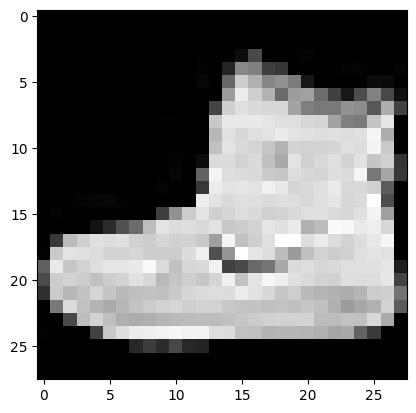

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [7]:
from torch.utils.data import DataLoader

batch_size = 100
data_loader = DataLoader(fmnist_dataset, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 7, 7, 1, 2, 7, 0, 1, 0, 9, 4, 2, 1, 8, 4, 8, 4, 6, 5, 7, 6, 4, 7, 7,
        1, 5, 0, 8, 2, 1, 0, 9, 1, 8, 3, 5, 3, 6, 1, 4, 2, 9, 2, 6, 1, 8, 5, 2,
        0, 2, 6, 2, 7, 0, 6, 3, 8, 7, 1, 8, 8, 5, 8, 8, 1, 6, 0, 6, 7, 1, 0, 9,
        7, 3, 8, 3, 8, 9, 7, 6, 2, 4, 4, 2, 4, 7, 2, 9, 6, 1, 4, 9, 7, 4, 0, 7,
        0, 7, 7, 5])


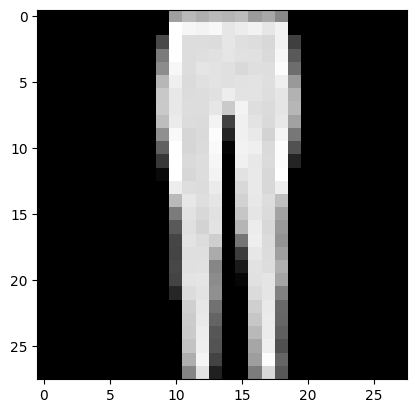

In [8]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [12]:
import torch.nn as nn

image_size = 784
hidden_size = 256

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);
latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

G.to(device);


In [13]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

In [14]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

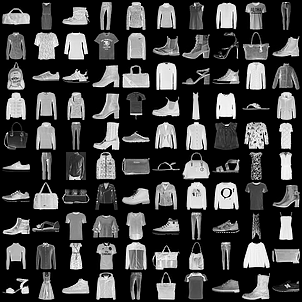

In [15]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Saving fake_images-0000.png


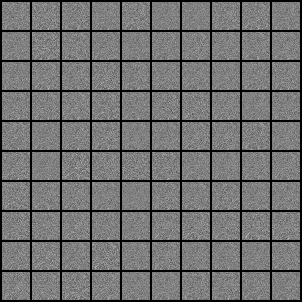

In [16]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

Step2. Train the GAN model to produce images in this new domain.


In [17]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)


Epoch [0/300], Step [200/600], d_loss: 0.0483, g_loss: 4.4296, D(x): 0.99, D(G(z)): 0.03
Epoch [0/300], Step [400/600], d_loss: 0.0607, g_loss: 5.7472, D(x): 0.97, D(G(z)): 0.03
Epoch [0/300], Step [600/600], d_loss: 0.0237, g_loss: 5.2119, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0622, g_loss: 4.4776, D(x): 0.98, D(G(z)): 0.03
Epoch [1/300], Step [400/600], d_loss: 0.0823, g_loss: 4.5056, D(x): 0.97, D(G(z)): 0.04
Epoch [1/300], Step [600/600], d_loss: 0.0306, g_loss: 5.9670, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0228, g_loss: 4.9994, D(x): 1.00, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0060, g_loss: 7.6196, D(x): 1.00, D(G(z)): 0.00
Epoch [2/300], Step [600/600], d_loss: 0.0046, g_loss: 7.0593, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0258, g_loss: 5.2851, D(x): 0.99, D(G(z)): 0.01
Epoch [3/300], Step [400/6

Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.




Saved: sample_300_1.png
Saved: sample_300_2.png
Saved: sample_300_3.png


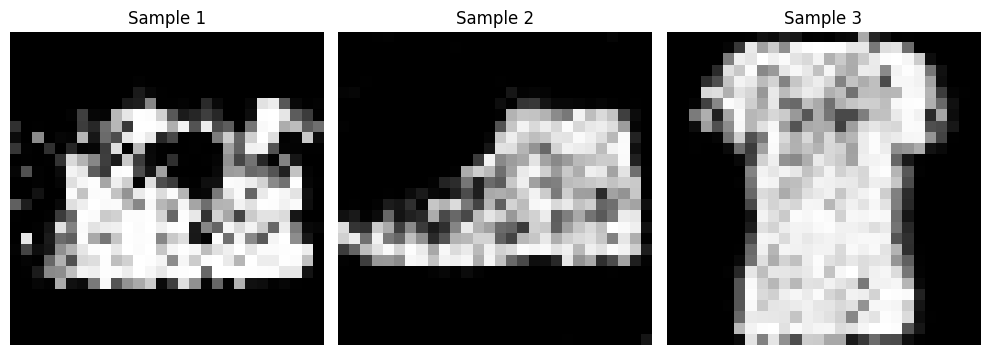

In [18]:
import matplotlib.pyplot as plt

# Function to save and display generated images
def save_and_display_samples(generator, latent_size, num_samples=3, index=9999):
    # Generate latent vectors for `num_samples` images
    sample_vectors = torch.randn(num_samples, latent_size).to(device)

    # Generate fake images
    fake_images = generator(sample_vectors)
    fake_images = denorm(fake_images.reshape(fake_images.size(0), 1, 28, 28).detach().cpu())

    # Save images
    for i in range(num_samples):
        fname = f'sample_{index}_{i+1}.png'
        save_image(fake_images[i], os.path.join(sample_dir, fname))
        print('Saved:', fname)

    # Display the saved images
    fig, axes = plt.subplots(1, num_samples, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Sample {i + 1}")

    plt.tight_layout()
    plt.show()

# Call the function to save and display 3 samples
save_and_display_samples(G, latent_size, num_samples=3, index=num_epochs)

the images are blurry and hard to detect

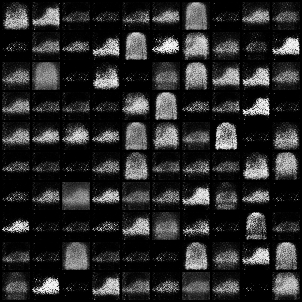

In [31]:
Image('./samples/fake_images-0010.png')

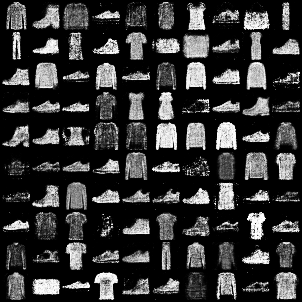

In [32]:
Image('./samples/fake_images-0300.png')

Step4. Save the model weights in the folder to be used later.



In [22]:
# Step 4: Save the model weights for both Generator and Discriminator
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(G.state_dict(), os.path.join(model_dir, 'G.pth'))
torch.save(D.state_dict(), os.path.join(model_dir, 'D.pth'))

print("Model weights saved successfully.")

Model weights saved successfully.


Step5. Load the model using the saved weights.


In [23]:
# Step 5: Load the model using the saved weights
# Create new instances of the Generator and Discriminator
G_loaded = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D_loaded = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Load the saved weights into the model instances
G_loaded.load_state_dict(torch.load(os.path.join(model_dir, 'G.pth')))
D_loaded.load_state_dict(torch.load(os.path.join(model_dir, 'D.pth')))

# Move models to appropriate device
G_loaded.to(device)
D_loaded.to(device)

print("Model weights loaded successfully.")

Model weights loaded successfully.


<ipython-input-23-534b67254b3e>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_loaded.load_state_dict(torch.load(os.path.join(model_dir, 'G.pth')))
<ipython-input-23-53


Step 6: Re-train the GAN model to see if you can improve.

Epoch [0/100], Step [200/600], d_loss: 1.0231, g_loss: 1.3599, D(x): 0.68, D(G(z)): 0.36
Epoch [0/100], Step [400/600], d_loss: 0.9783, g_loss: 1.4084, D(x): 0.68, D(G(z)): 0.32
Epoch [0/100], Step [600/600], d_loss: 0.9255, g_loss: 1.2951, D(x): 0.70, D(G(z)): 0.32
Saving fake_images-0301.png
Epoch [1/100], Step [200/600], d_loss: 0.7671, g_loss: 1.4347, D(x): 0.74, D(G(z)): 0.27
Epoch [1/100], Step [400/600], d_loss: 1.2960, g_loss: 1.1297, D(x): 0.64, D(G(z)): 0.42
Epoch [1/100], Step [600/600], d_loss: 0.9842, g_loss: 1.0745, D(x): 0.74, D(G(z)): 0.40
Saving fake_images-0302.png
Epoch [2/100], Step [200/600], d_loss: 0.9215, g_loss: 1.5162, D(x): 0.68, D(G(z)): 0.32
Epoch [2/100], Step [400/600], d_loss: 0.9248, g_loss: 1.4454, D(x): 0.70, D(G(z)): 0.35
Epoch [2/100], Step [600/600], d_loss: 0.9671, g_loss: 1.5247, D(x): 0.67, D(G(z)): 0.33
Saving fake_images-0303.png
Epoch [3/100], Step [200/600], d_loss: 1.1455, g_loss: 1.2375, D(x): 0.69, D(G(z)): 0.38
Epoch [3/100], Step [400/6

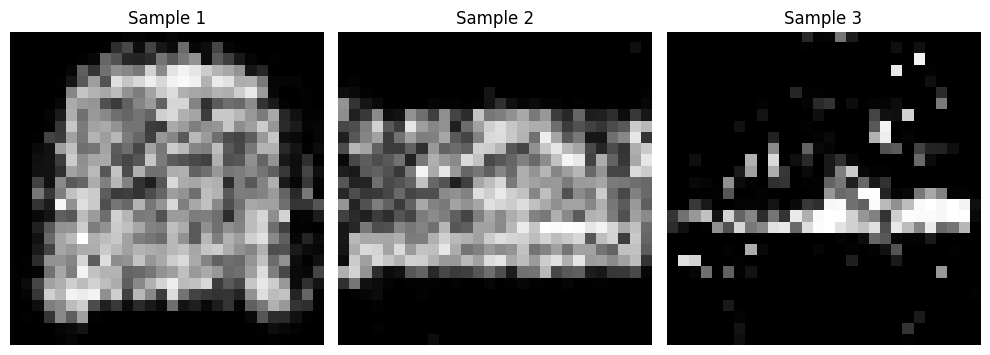

In [24]:
# Re-train the GAN model (continuation training)
num_epochs = 100  # Additional training epochs to try to improve the model
total_step = len(data_loader)

# Initialize lists for logging the new training results
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator using the LSGAN methods (if applicable)
        d_loss, real_score, fake_score = train_discriminator(images)  # or train_discriminator_lsgan(images)
        g_loss, fake_images = train_generator()  # or train_generator_lsgan()

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images for inspection
    save_fake_images(epoch + 1 + 300)  # Epoch offset by the previous training (e.g., if first 300 epochs finished)

print("Retraining completed.")

# Save and display new samples generated from retrained model
save_and_display_samples(G, latent_size, num_samples=3, index=num_epochs + 300)

Step 7: Save the model weights without using checkpoints.

In [25]:
#  Save the updated model weights for both Generator and Discriminator
torch.save(G.state_dict(), os.path.join(model_dir, 'G_updated.pth'))
torch.save(D.state_dict(), os.path.join(model_dir, 'D_updated.pth'))

print("Updated model weights saved successfully.")

Updated model weights saved successfully.



Step 8: Load the model weights without using checkpoints.

Updated model weights loaded successfully.


<ipython-input-26-bbe7bf9830ec>:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_loaded_updated.load_state_dict(torch.load(os.path.join(model_dir, 'G_updated.pth')))
<ipy

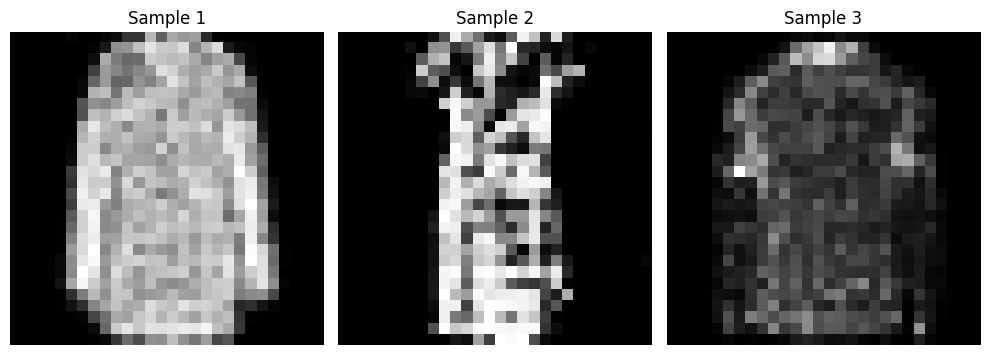

In [26]:
# Load the model using the saved weights without using checkpoints

# Create new instances of the Generator and Discriminator
G_loaded_updated = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

D_loaded_updated = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Load the saved weights into the model instances
G_loaded_updated.load_state_dict(torch.load(os.path.join(model_dir, 'G_updated.pth')))
D_loaded_updated.load_state_dict(torch.load(os.path.join(model_dir, 'D_updated.pth')))

# Move models to appropriate device
G_loaded_updated.to(device)
D_loaded_updated.to(device)

print("Updated model weights loaded successfully.")

# Generate and display new samples using the loaded updated generator
sample_vectors = torch.randn(3, latent_size).to(device)
fake_images = G_loaded_updated(sample_vectors)
fake_images = denorm(fake_images.reshape(fake_images.size(0), 1, 28, 28).detach().cpu())

# Display the new samples
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(fake_images[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {i + 1}")

plt.tight_layout()
plt.show()

Generated Samples from Retrained GAN:
Saved: sample_400.png


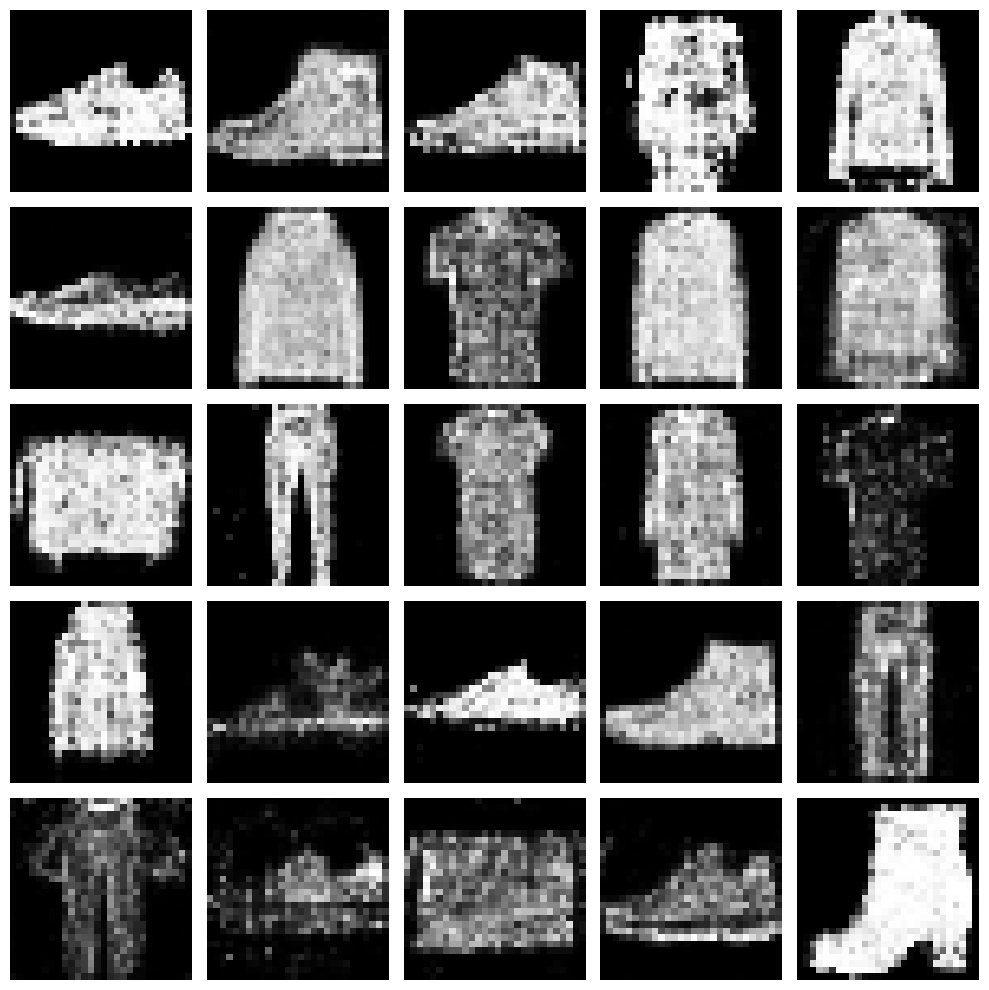

In [27]:
import matplotlib.pyplot as plt

# Updated function to save and display more generated images
def save_and_display_samples(generator, latent_size, num_samples=25, index=9999):
    # Generate latent vectors for `num_samples` images
    sample_vectors = torch.randn(num_samples, latent_size).to(device)

    # Generate fake images
    fake_images = generator(sample_vectors)
    fake_images = denorm(fake_images.reshape(fake_images.size(0), 1, 28, 28).detach().cpu())

    # Save images
    fname = f'sample_{index}.png'
    save_image(fake_images, os.path.join(sample_dir, fname), nrow=int(num_samples ** 0.5))
    print('Saved:', fname)

    # Display the saved images
    fig, axes = plt.subplots(int(num_samples ** 0.5), int(num_samples ** 0.5), figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Generate and display many samples from the retrained GAN model
print("Generated Samples from Retrained GAN:")
save_and_display_samples(G, latent_size, num_samples=25, index=num_epochs + 300)

Part 2 **LSGAN**:

Epoch [1/300], d_loss: 0.0044, g_loss: 1.0298
Epoch [2/300], d_loss: 0.0157, g_loss: 1.0604
Epoch [3/300], d_loss: 0.0320, g_loss: 0.9771
Epoch [4/300], d_loss: 0.0269, g_loss: 1.0868
Epoch [5/300], d_loss: 0.0193, g_loss: 1.0001
Epoch [6/300], d_loss: 0.0221, g_loss: 1.0208
Epoch [7/300], d_loss: 0.0349, g_loss: 0.9615
Epoch [8/300], d_loss: 0.0305, g_loss: 1.2901
Epoch [9/300], d_loss: 0.0650, g_loss: 1.0094
Epoch [10/300], d_loss: 0.0413, g_loss: 1.0035
Epoch [11/300], d_loss: 0.0497, g_loss: 0.9491
Epoch [12/300], d_loss: 0.0451, g_loss: 1.0106
Epoch [13/300], d_loss: 0.1269, g_loss: 0.9491
Epoch [14/300], d_loss: 0.0818, g_loss: 1.0602
Epoch [15/300], d_loss: 0.1130, g_loss: 1.0216
Epoch [16/300], d_loss: 0.0599, g_loss: 0.9932
Epoch [17/300], d_loss: 0.0906, g_loss: 0.8275
Epoch [18/300], d_loss: 0.0664, g_loss: 0.9533
Epoch [19/300], d_loss: 0.1218, g_loss: 0.8359
Epoch [20/300], d_loss: 0.1219, g_loss: 1.0273
Epoch [21/300], d_loss: 0.1338, g_loss: 0.8039
Epoch [22/300], d_loss

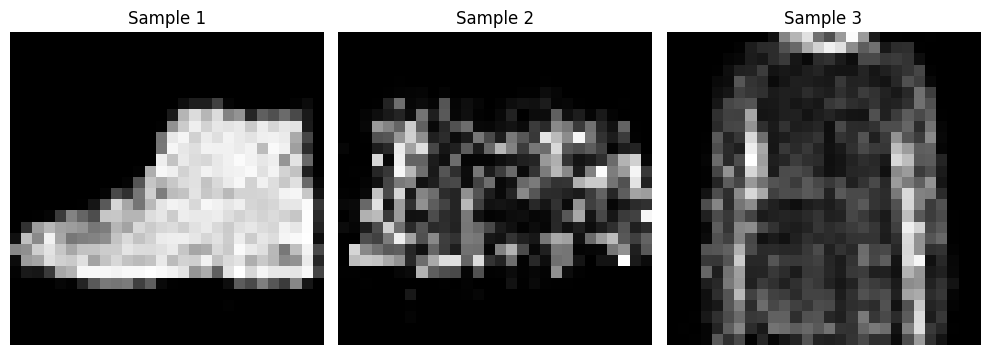

Model weights saved successfully.
Model weights loaded successfully.


<ipython-input-28-0d61df35ece6>:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_loaded.load_state_dict(torch.load(os.path.join(model_dir, 'G_lsgan.pth')))
<ipython-inpu

Epoch [1/100], d_loss: 0.2712, g_loss: 0.4586
Epoch [2/100], d_loss: 0.2910, g_loss: 0.5073
Epoch [3/100], d_loss: 0.3419, g_loss: 0.5067
Epoch [4/100], d_loss: 0.3176, g_loss: 0.5044
Epoch [5/100], d_loss: 0.3228, g_loss: 0.4461
Epoch [6/100], d_loss: 0.3486, g_loss: 0.4724
Epoch [7/100], d_loss: 0.3319, g_loss: 0.4248
Epoch [8/100], d_loss: 0.3342, g_loss: 0.4840
Epoch [9/100], d_loss: 0.3281, g_loss: 0.4414
Epoch [10/100], d_loss: 0.3032, g_loss: 0.5160
Epoch [11/100], d_loss: 0.3515, g_loss: 0.4704
Epoch [12/100], d_loss: 0.3528, g_loss: 0.4568
Epoch [13/100], d_loss: 0.3231, g_loss: 0.4941
Epoch [14/100], d_loss: 0.2823, g_loss: 0.4904
Epoch [15/100], d_loss: 0.2964, g_loss: 0.4896
Epoch [16/100], d_loss: 0.2933, g_loss: 0.5093
Epoch [17/100], d_loss: 0.3434, g_loss: 0.4748
Epoch [18/100], d_loss: 0.3598, g_loss: 0.4748
Epoch [19/100], d_loss: 0.3030, g_loss: 0.4433
Epoch [20/100], d_loss: 0.3272, g_loss: 0.4525
Epoch [21/100], d_loss: 0.2931, g_loss: 0.4598
Epoch [22/100], d_loss

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from torchvision.utils import save_image

# Hyperparameters
latent_size = 64
hidden_size = 256
image_size = 784
batch_size = 100
num_epochs = 300
learning_rate = 0.0002

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 1: Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
fmnist_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(fmnist_dataset, batch_size=batch_size, shuffle=True)

# Generator Model
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

# Discriminator Model
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1)
).to(device)

# Loss function and optimizers for LSGAN
criterion = nn.MSELoss()
g_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate)

# Denormalization function
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Reset gradients function
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Save directory for generated samples
sample_dir = 'samples_lsgan'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

# Function to save generated fake images
def save_fake_images(index):
    sample_vectors = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Step 2: Training loop for LSGAN
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Prepare real and fake data
        images = images.reshape(batch_size, -1).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)  # Real labels for LSGAN (value of 1)
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Fake labels for LSGAN (value of 0)

        # Train the discriminator
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)  # The generator tries to make D output `1` for its fakes

        reset_grad()
        g_loss.backward()
        g_optimizer.step()

    # Save generated images every epoch
    save_fake_images(epoch + 1)

    # Logging
    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

# Step 3: Save and display generated samples
sample_vectors = torch.randn(3, latent_size).to(device)
fake_images = G(sample_vectors)
fake_images = denorm(fake_images.reshape(fake_images.size(0), 1, 28, 28).detach().cpu())

# Display the new samples
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, ax in enumerate(axes):
    ax.imshow(fake_images[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Sample {i + 1}")

plt.tight_layout()
plt.show()

# Difficulties Faced:
# - The generated images may initially appear blurry or not well-defined, requiring more training epochs.
# - GANs are notoriously unstable to train, and LSGAN helps improve stability, but mode collapse can still occur.

# Step 4: Save model weights
model_dir = 'models_lsgan'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(G.state_dict(), os.path.join(model_dir, 'G_lsgan.pth'))
torch.save(D.state_dict(), os.path.join(model_dir, 'D_lsgan.pth'))
print("Model weights saved successfully.")

# Step 5: Load the model using the saved weights
G_loaded = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
).to(device)

D_loaded = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1)
).to(device)

G_loaded.load_state_dict(torch.load(os.path.join(model_dir, 'G_lsgan.pth')))
D_loaded.load_state_dict(torch.load(os.path.join(model_dir, 'D_lsgan.pth')))
print("Model weights loaded successfully.")

# Step 6: Re-train the LSGAN model to see if you can improve
# Retrain using the loaded model
num_epochs_retrain = 100
for epoch in range(num_epochs_retrain):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator
        outputs = D_loaded(images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G_loaded(z)
        outputs = D_loaded(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train the generator
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G_loaded(z)
        outputs = D_loaded(fake_images)
        g_loss = criterion(outputs, real_labels)

        reset_grad()
        g_loss.backward()
        g_optimizer.step()

    # Logging
    print(f'Epoch [{epoch+1}/{num_epochs_retrain}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

print("Retraining completed.")

Now , we can compare the results

Generated Samples from GAN:


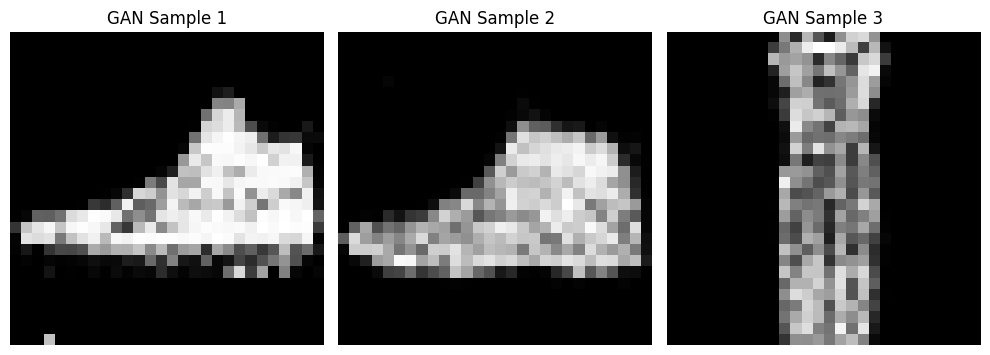

Generated Samples from LSGAN:


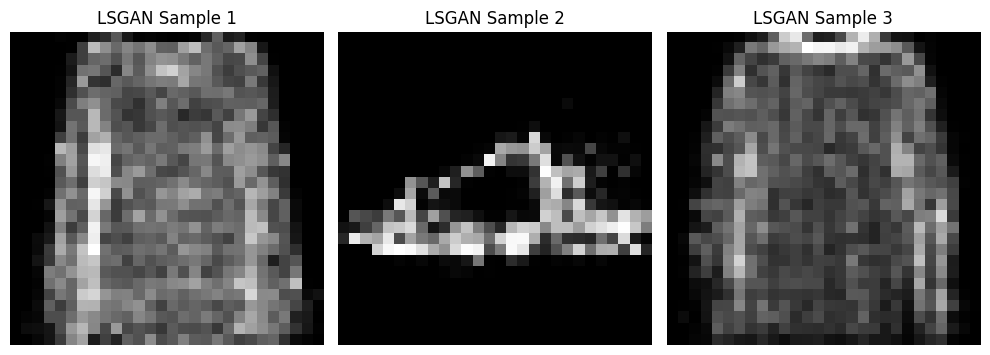

In [29]:
# Generate and display 3 samples from both GAN and LSGAN
def display_generated_samples(generator, label, latent_size):
    # Generate sample latent vectors
    sample_vectors = torch.randn(3, latent_size).to(device)

    # Generate fake images
    fake_images = generator(sample_vectors)
    fake_images = denorm(fake_images.reshape(fake_images.size(0), 1, 28, 28).detach().cpu())

    # Display generated images
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"{label} Sample {i + 1}")
    plt.tight_layout()
    plt.show()

# Display samples from GAN
print("Generated Samples from GAN:")
display_generated_samples(G_loaded_updated, 'GAN', latent_size)

# Display samples from LSGAN
print("Generated Samples from LSGAN:")
display_generated_samples(G_loaded, 'LSGAN', latent_size)

Observations:

GAN Results: • The images generated by the conventional GAN are identifiable but very blurred. • Cloths have some identifiable structure, but unsharply and indistinctly like the shoes and shirts. • Some of the images are of strong artifacts/noises; hence, this is evidence that the generator is not coherently changing the underlying features of Fashion MNIST.
LSGAN Results: • LSGAN, bottom row: marginal improvements in clarity. • Sharper and more distinguishable images are shoes, for instance, LSGAN Image 5, and shirts, for example, Example LSGAN Image 2. • LSGAN uses a different loss function that allows smoother training, and it also seems that these images have slightly less noise compared to the traditional GAN.

Generated Samples from Retrained GAN:
Saved: GAN_sample_GAN_large_grid.png


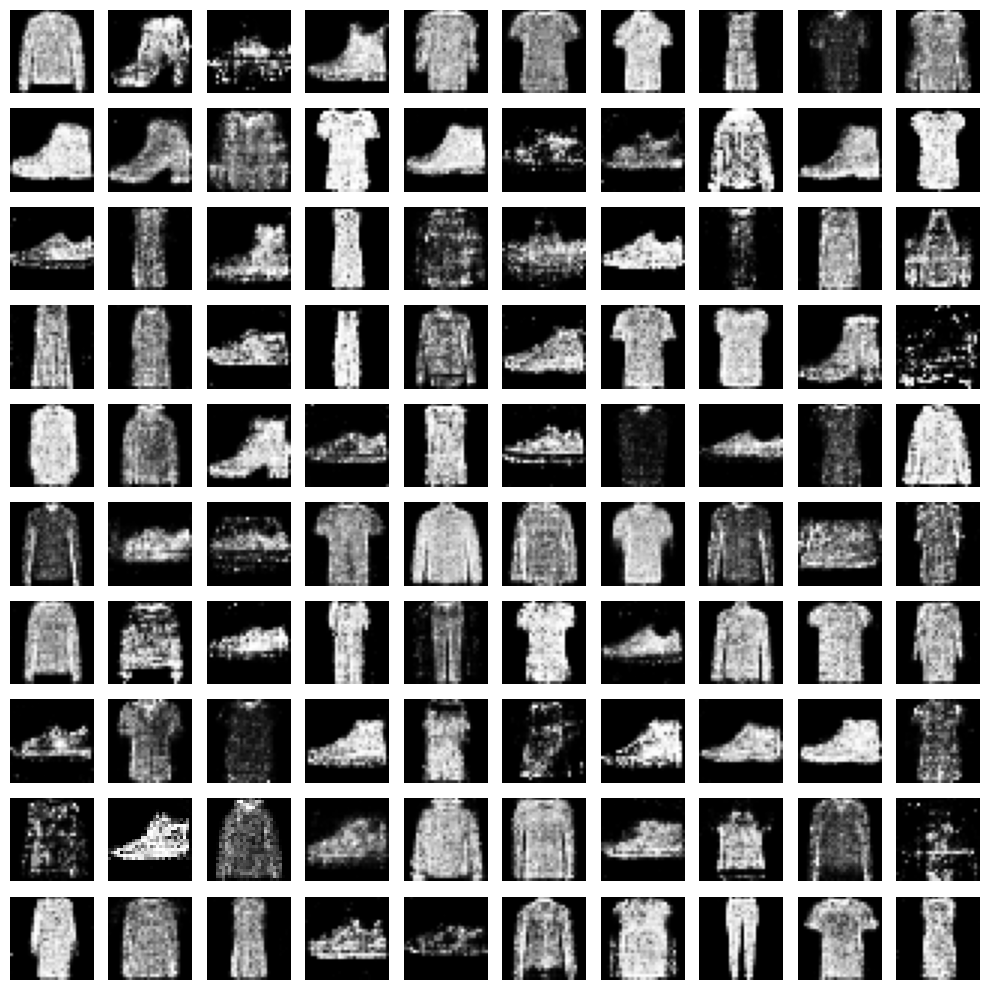

Generated Samples from Retrained LSGAN:
Saved: LSGAN_sample_LSGAN_large_grid.png


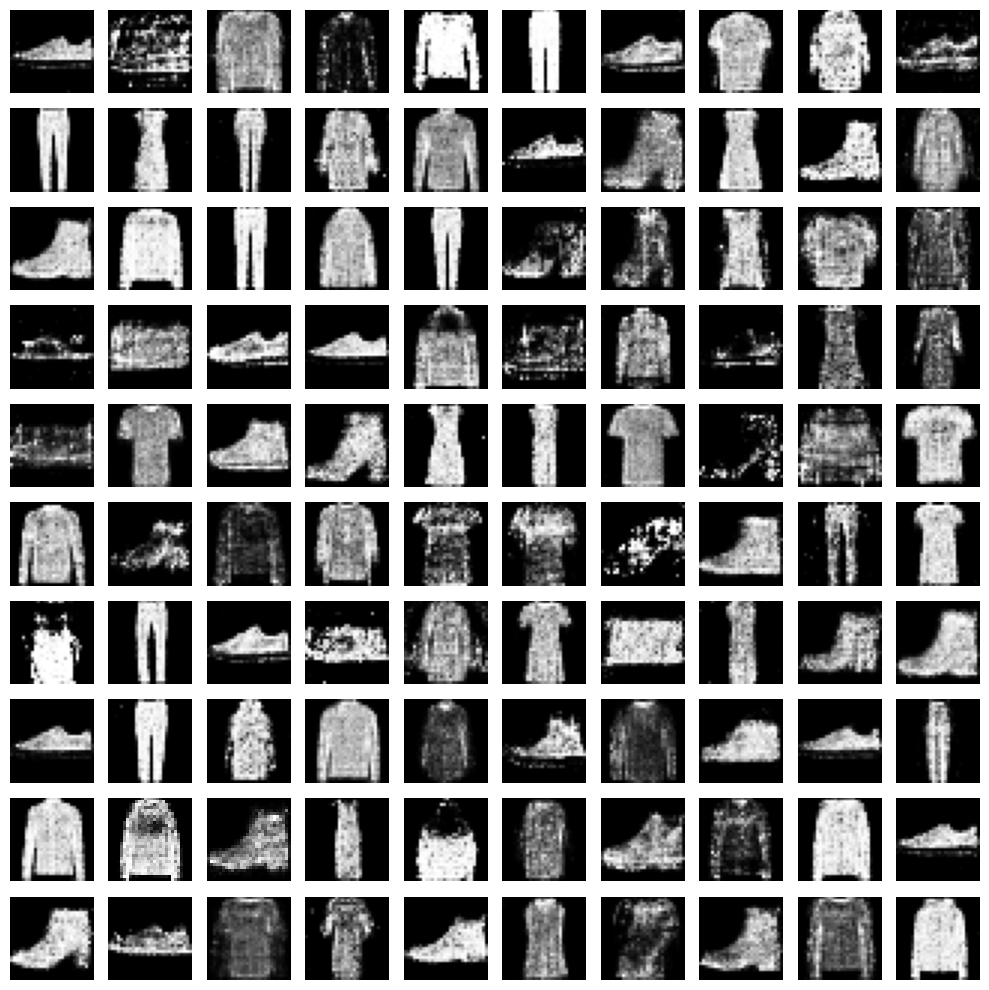

In [30]:
import matplotlib.pyplot as plt

# Function to save and display generated images in a large grid
def save_and_display_samples(generator, latent_size, num_samples=100, index=9999, model_name=""):
    # Generate latent vectors for `num_samples` images
    sample_vectors = torch.randn(num_samples, latent_size).to(device)

    # Generate fake images
    fake_images = generator(sample_vectors)
    fake_images = denorm(fake_images.reshape(fake_images.size(0), 1, 28, 28).detach().cpu())

    # Save images
    fname = f'{model_name}_sample_{index}.png'
    save_image(fake_images, os.path.join(sample_dir, fname), nrow=int(num_samples ** 0.5))
    print('Saved:', fname)

    # Display the saved images in a grid format
    num_rows = int(num_samples ** 0.5)
    num_cols = int(num_samples ** 0.5)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(fake_images[i].squeeze(), cmap='gray')
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)  # Remove spacing between images
    plt.tight_layout()
    plt.show()

# Generate and display many samples from the retrained GAN model in a large grid format
print("Generated Samples from Retrained GAN:")
save_and_display_samples(G_loaded_updated, latent_size, num_samples=100, index='GAN_large_grid', model_name="GAN")

# Generate and display many samples from the retrained LSGAN model in a large grid format
print("Generated Samples from Retrained LSGAN:")
save_and_display_samples(G_loaded, latent_size, num_samples=100, index='LSGAN_large_grid', model_name="LSGAN")